In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [40]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values

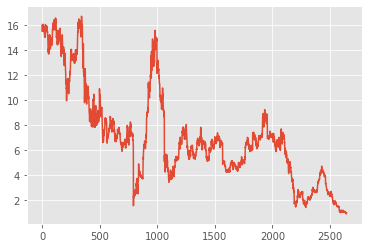

In [42]:
plt.plot(data)

plt.show()

In [43]:
data.shape

(2645,)

In [133]:
def ornstein_uhlenbeck_process(n, m, mu):
    res = []
    theta = 1
    sigma = 1
    # mu = 0.0
    T = 1
    
    for j in range(m):
        x = np.zeros(n + 1)
        s = np.zeros(n + 1)
        time = np.zeros(n + 1)
        
        x[0] = np.random.normal(0, 0.1)
        dt = T/float(n)

        for t in range(n):
            x[t+1] = x[t] + theta*(mu - x[t]) * dt + sigma * np.sqrt(dt) * np.random.normal(loc=0, scale=1)
            time[t+1] = time[t] + dt

        res.append(x)
    
    return np.array(res).T

def dclProcess(N, M):
    T = 10
    theta = 3
    delta = 2

    Z1 = np.random.normal(0.0, 1.0, [M, N])
    X = np.zeros([M, N + 1])

    X[:, 0] = np.random.normal(0.0, 0.2, M)

    time = np.zeros([N+1])
    dt = T / float(N)
    
    for i in range(0, N):

        X[:,i+1] = X[:, i] - 1/theta * X[:,i] * dt + np.sqrt((1 - (X[:, i])**2)/(theta * (delta + 1))) * np.sqrt(dt) * Z1[:,i]
            
        if (X[:,i+1] > 1).any():
            X[np.where(X[:,i+1] >= 1)[0], i+1] = 0.9999

        if (X[:,i+1] < -1).any():
            X[np.where(X[:,i+1] <= -1)[0], i+1] = -0.9999 
            
        time[i+1] = time[i] + dt

    return X.T

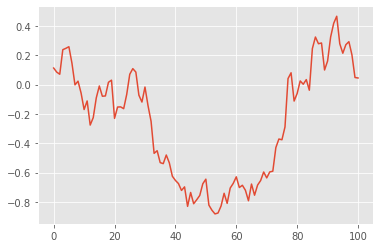

In [31]:
plt.plot(dclProcess(100, 20).T[1])

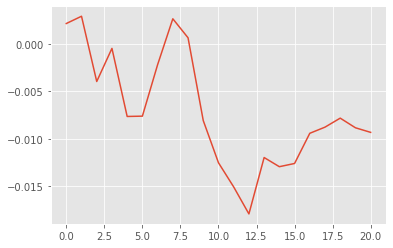

In [73]:
plt.plot(np.mean(ornstein_uhlenbeck_process(20, 1000).T, axis=0))

In [135]:
z = np.mean(ornstein_uhlenbeck_process(2500, 100, np.mean(data)), axis=1)

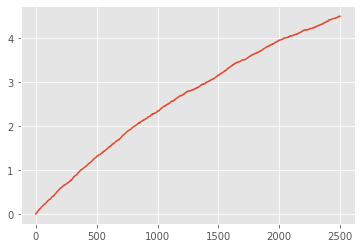

In [137]:
plt.plot(z)

plt.show()

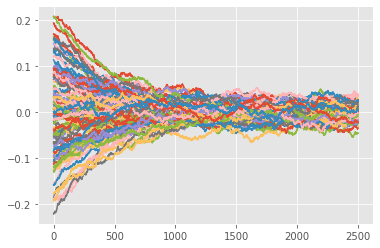

In [104]:
plt.plot(ornstein_uhlenbeck_process(2500, 100))

plt.show()

In [158]:
def split_series_adapted(x):
    k = 2
    train_sample = []

    for _ in range(1, len(x)):
        train_sample.append(x[:k])
        k += 1

    return train_sample

In [160]:
z_train = split_series_adapted(z)

In [181]:
data_train = split_series_adapted(data)

In [221]:
class Drift(nn.Module):
    def __init__(self, data_dim):
        super(Drift, self).__init__()

        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.data_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim))

    def forward(self, x):
        out = self.model(x)
        return out
    
class Diffusion(nn.Module):
    def __init__(self, data_dim):
        super(Diffusion, self).__init__()

        self.data_dim = data_dim

        self.model = nn.Sequential(nn.Linear(self.data_dim, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, 2**7),
                                   nn.ReLU(),
                                   nn.Linear(2**7, self.data_dim))

    def forward(self, x):
        out = self.model(x)
        return out

In [222]:
drift = Drift(1)
diffusion = Diffusion(1)

In [223]:
optim_drift = optim.Adam(drift.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3, betas=(0.9, 0.999), amsgrad=True)

In [185]:
data_train = list(map(lambda x: torch.FloatTensor(x.reshape(-1, 1)), data_train))

In [215]:
data_train = data_train[:10]

In [187]:
# train_loader = DataLoader(data_train, shuffle=False)

In [231]:
epochs = tqdm(range(1000))

for _ in epochs:
    for idx in range(len(data_train)):
        loss = nn.MSELoss()

        noise = torch.FloatTensor(z_train[idx].reshape(-1, 1))

        a = torch.sum(drift(noise))
        b = torch.sum(diffusion(noise))

        x = np.zeros(len(noise))
        dt = 0.1
        for i in range(len(noise) - 1):
            x[i+1] = x[i] + a * dt + b * np.sqrt(dt) * np.random.normal(0, 1)

        x = Variable(torch.FloatTensor(x.reshape(-1, 1)), requires_grad=True)

        criterion = loss(data_train[idx], x)

        optim_drift.zero_grad()
        optim_diffusion.zero_grad()

        criterion.backward()

        optim_drift.step()
        optim_diffusion.step()

    epochs.set_description(f'Loss {criterion.item()}')


Loss 239.21932983398438: 100%|██████████| 1000/1000 [00:06<00:00, 150.61it/s]


In [237]:
torch.sum(drift(torch.FloatTensor(z_train[0].reshape(-1, 1))))

tensor(0.0519, grad_fn=<SumBackward0>)

In [243]:
a = torch.sum(drift(torch.FloatTensor(z_train[5].reshape(-1, 1)))).detach().cpu().numpy()
b = torch.sum(diffusion(torch.FloatTensor(z_train[5].reshape(-1, 1)))).detach().cpu().numpy()

x = np.zeros(len(noise) + 1)
dt = 0.1

for i in range(len(z_train[5]) - 1):
    x[i+1] = x[i] + a * dt + b * np.sqrt(dt) * np.random.normal(0, 1)

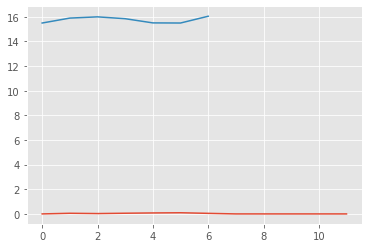

In [244]:
plt.plot(x)
plt.plot(data_train[5])